In [1]:
using Pkg
TAMBOPATH = "/Users/jlazar/research/TAMBO-MC/"
Pkg.activate("$(TAMBOPATH)/Tambo/")
using Tambo

  Activating project at `~/research/TAMBO-MC/Tambo`
┌ Info: Precompiling Tambo [d9a96183-4919-46da-8188-64ea4e10e0ed]
└ @ Base loading.jl:1664


In [2]:
using Dierckx
using PyCall
using HDF5
using Pkg
using Interpolations
using Integrals
using ProgressBars
using Roots

┌ Info: Precompiling Integrals [de52edbc-65ea-441a-8357-d3a637375a31]
└ @ Base loading.jl:1664
┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240


In [3]:
differential_xss = h5open("$(TAMBOPATH)/resources/cross_sections/tables/csms_differential.h5");

In [4]:
include("$(TAMBOPATH)/paperstyle.jl")

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1664


In [5]:
EMIN = 10 * units.GeV
ZS = differential_xss["zs"][:]
d = Dict()

HACK = 1e40

for key in ProgressBar(keys(differential_xss))
  if ~occursin("nu", key)
    continue
  end
  total_xs = []
  for idx in 1:501
    
    energy = 10 ^ differential_xss["energies"][idx]
    diff_xs = differential_xss[key][idx, :]

    mask = diff_xs .> 1e-50

    fine_zs = LinRange(0, ZS[mask][end], 10000)

    itp = LinearInterpolation(ZS[mask], log.(10, diff_xs[mask]))
    plt = plot(ZS[mask], log.(10, diff_xs[mask]), lw=6)
    plot!(plt, fine_zs, itp(fine_zs))
    f(z, p) = 10 ^ itp(z)
    # f(z, p) = 10 ^ itp(z) * HACK
    prob = IntegralProblem(f, 0.0, ZS[mask][end], 1)
    sol = solve(prob, QuadGKJL())
    push!(total_xs, sol.u)
    # push!(total_xs, sol.u / HACK)
  end
  d[key] = total_xs
end

0.0%┣                                               ┫ 0/14 [00:00<00:-1, -0s/it]
7.1%┣███                                        ┫ 1/14 [00:00<Inf:Inf, InfGs/it]
14.3%┣██████▊                                        ┫ 2/14 [00:05<01:05, 5s/it]
21.4%┣██████████                                     ┫ 3/14 [00:06<00:33, 3s/it]
28.6%┣█████████████▍                                 ┫ 4/14 [00:07<00:23, 2s/it]
35.7%┣████████████████▉                              ┫ 5/14 [00:07<00:17, 2s/it]
42.9%┣████████████████████▏                          ┫ 6/14 [00:08<00:13, 2s/it]
50.0%┣███████████████████████▌                       ┫ 7/14 [00:09<00:10, 1s/it]
57.1%┣██████████████████████████▉                    ┫ 8/14 [00:09<00:08, 1s/it]
64.3%┣██████████████████████████████▏                ┫ 9/14 [00:10<00:06, 1s/it]
71.4%┣████████████████████████████████▉             ┫ 10/14 [00:11<00:05, 1s/it]
78.6%┣████████████████████████████████████▏         ┫ 11/14 [00:11<00:03, 1s/it]
85.7%┣██████████████████████

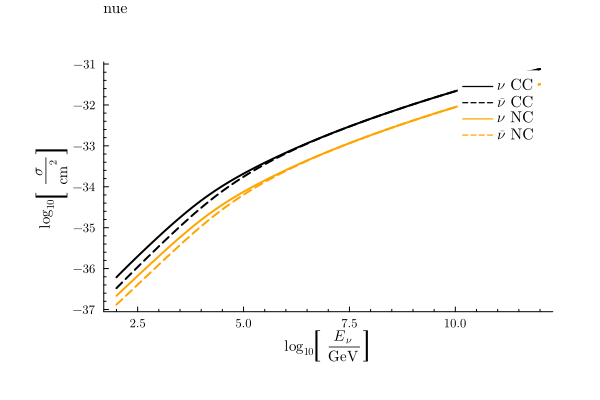

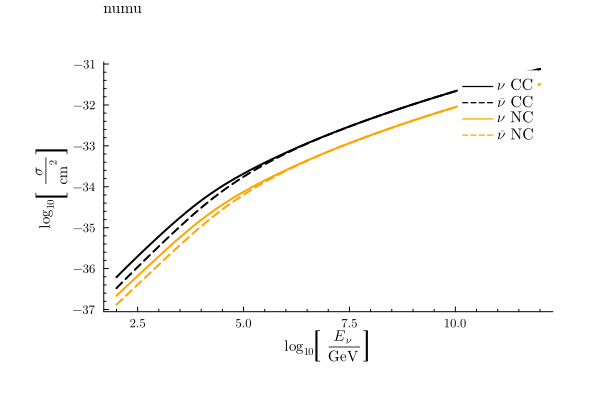

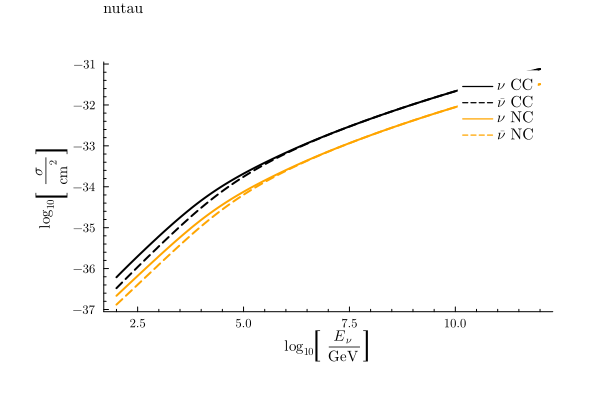

In [6]:
for k in ["nue", "numu", "nutau"]
    v = d["$(k)_nu_CC"]
    plt = plot(differential_xss["energies"][:] .- 9, log.(10, v), margin=1cm, size=(600, 400), label=L"\nu"*" CC", c=:black)
    v = d["$(k)_nubar_CC"]
    plot!(plt, differential_xss["energies"][:] .- 9, log.(10, v), margin=1cm, size=(600, 400), label=L"\bar{\nu}"*" CC", c=:black, ls=:dash)
    v = d["$(k)_nu_NC"]
    plot!(plt, differential_xss["energies"][:] .- 9, log.(10, v), margin=1cm, size=(600, 400), label=L"\nu"*" NC", c=:orange)
    v = d["$(k)_nubar_NC"]
    plot!(plt, differential_xss["energies"][:] .- 9, log.(10, v), margin=1cm, size=(600, 400), label=L"\bar{\nu}"*" NC", c=:orange, ls=:dash)
    title!(plt, k)
    ylabel!(plt, L"\log_{10}\left[\frac{\sigma}{\mathrm{cm}^2}\right]")
    xlabel!(plt, L"\log_{10}\left[\frac{E_{\nu}}{\mathrm{GeV}}\right]")
    display(plt)
end

In [10]:
outfile = h5open("/Users/jlazar/research/TAMBO-MC/resources/cross_sections/tables/csms_total_cross_section.h5", "w")
outfile["log_energies"] = differential_xss["energies"][:]
for (k, v) in d
    outfile["log_$(k)"] = log.(10.0, v .* units.cm .^ 2)
end;
close(outfile)

In [208]:
outfile = h5open("$(TAMBOPATH)/resources/cross_sections/tables/csms_differential_cross_section.h5", "w")
outfile["log_energymin"] = 10.0
for k in keys(differential_xss)
  if occursin("nu", k)
    outfile["log_$(k)"] = log.(10, differential_xss[k][:, :] * units.cm ^ 2)
  elseif k=="energies"
    outfile["log_$(k)"] = differential_xss[k][:]
  else
    outfile[k] = differential_xss[k][:]
  end
end
close(outfile)

In [17]:
EMIN = 10 * units.GeV
ZS = differential_xss["zs"][:]
cdf_dict = Dict()

for key in keys(differential_xss)
  println(key)
  if ~occursin("nu", key)
    continue
  end
  tot_xs = d[key]
  cdfs = ones((size(differential_xss["energies"])[1], size(differential_xss["zs"])[1]))
  for idx in 1:501
    
    diff_xs = differential_xss[key][idx, :]

    mask = diff_xs .> 1e-50

    itp = LinearInterpolation(ZS[mask], log.(10, diff_xs[mask]))
    f(z, p) = 10 ^ itp(z)
    
    for (jdx, z) in enumerate(ZS[mask])
      prob = IntegralProblem(f, 0.0, z, 1)
      sol = solve(prob, QuadGKJL())
      cdfs[idx, jdx] = sol.u / tot_xs[idx]
    end
  end
  cdf_dict[key] = cdfs
end

energies
nue_nu_CC
nue_nu_NC
nue_nubar_CC
nue_nubar_NC
numu_nu_CC
numu_nu_NC
numu_nubar_CC
numu_nubar_NC
nutau_nu_CC
nutau_nu_NC
nutau_nubar_CC
nutau_nubar_NC
zs


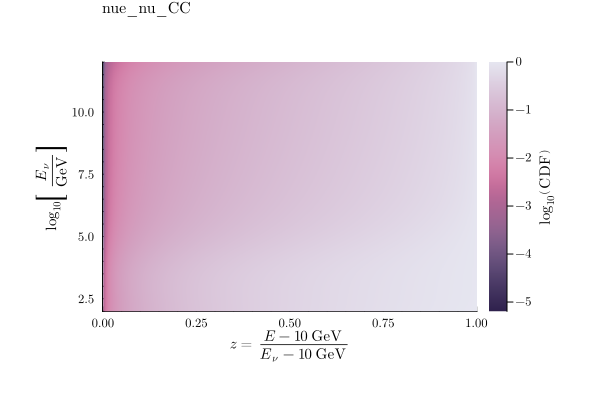

In [19]:
k = "nue_nu_CC"
hmap = heatmap(
  ZS,
  differential_xss["energies"] .- 9,
  log.(10, cdf_dict[k]),
  margin=1cm,
  size=(600, 400),
  color=cgrad(:acton),
  colorbar_title=L"\log_{10}\left(\mathrm{CDF}\right)"
)
xlabel!(hmap, L"$z=\frac{E - 10~\mathrm{GeV}}{E_{\nu} - 10~\mathrm{GeV}}$")
ylabel!(hmap, L"$\log_{10}\left[\frac{E_{\nu}}{\textrm{GeV}}\right]$")
title!(hmap, k)

In [21]:
us = LinRange(0, 1, 500)
inverted_cdf_dict = Dict()

for key in keys(differential_xss)
  println(key)
  if ~occursin("nu", key)
    continue
  end
  inverted_x = zeros((501, size(us)[1]))
  cdf = cdf_dict[key]
  for idx in 1:501
    x = cdf[idx, :]
    itp = LinearInterpolation(ZS, x)

    for (jdx, u) in enumerate(us)
      f(x) = itp(x) - u
      res = find_zero(f, (0,1))
      inverted_x[idx, jdx] = res
    end
  end
  inverted_cdf_dict[key] = inverted_x
end

energies
nue_nu_CC
nue_nu_NC
nue_nubar_CC
nue_nubar_NC
numu_nu_CC
numu_nu_NC
numu_nubar_CC
numu_nubar_NC
nutau_nu_CC
nutau_nu_NC
nutau_nubar_CC
nutau_nubar_NC
zs


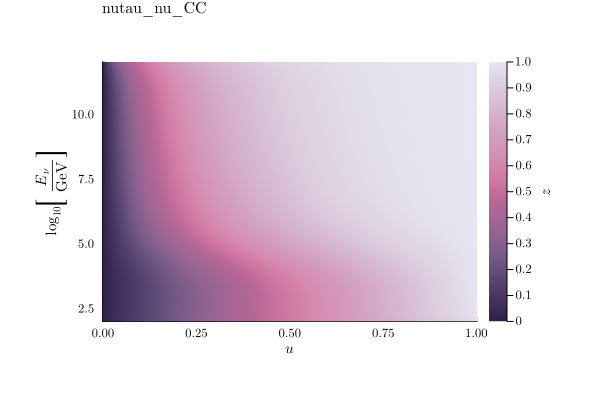

In [22]:
k = "nutau_nu_CC"
hmap = heatmap(
  us,
  differential_xss["energies"] .- 9,
  inverted_cdf_dict[k],
  margin=1cm,
  size=(600, 400),
  color=cgrad(:acton),
  colorbar_title=L"z"
)
xlabel!(hmap, L"u")
ylabel!(hmap, L"$\log_{10}\left[\frac{E_{\nu}}{\textrm{GeV}}\right]$")
title!(hmap, k)

In [25]:
cdf_file = h5open("/Users/jlazar/research/TAMBO-MC/resources/cross_sections/tables/csms_differential_cross_section_cdf.h5", "w")
cdf_file["us"] = Array(us)
cdf_file["log_energies"] = differential_xss["energies"][:]
cdf_file["log_energymin"] = 10.0
for (k, v) in inverted_cdf_dict
  cdf_file[k] = v
end
close(cdf_file)

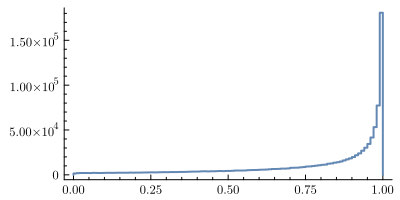

In [203]:
stephist(itp(19, rand(1000000)))